# NFL Predictions

## University of Denver Data Analytics Bootcamp

### August 7, 2019

**Presenters:**

* Tai Johnson
* Seth Oliver
* Matthew Stewart

---

## Purpose

The purpose of this project was to use machine learning to build a predictor for the outcomes of NFL matchups.  This was a classification problem, where the possible outcomes (classes) of results were Win, Lose, and Draw.

We extracted our data from the data sources listed below and cleaned the data using both Microsoft Excel and Python Pandas.  Finally, we built classification models using Logistic Regression, SVM, and Deep Learning; we then analyzed and visualized the results of these models.

### Data Sources

[NFL Historic Matchups](https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data/home#spreadspoke_scores.csv)  
[NFL Stadium Info](https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data/home#nfl_stadiums.csv)  

---

## Agenda

### -- Data Processing

### -- Initial Functions and Correlation Analysis

### -- Logistic Regression

### -- Support Vector Machine

### -- Deep Learning

### -- Conclusion

# 1.  Data Processing

## Dataset One:  NFL Historic Matchup

![alt text](Images/nfl_scores.png "NFL Historic Matchups")

## Dataset Two: NFL Stadiums

![alt text](Images/nfl_stadiums.png "NFL Stadiums")

## Combined Datasets

### Added stadium information to Dataset One using VLOOKUP

![alt text](Images/nfl_datasets_combined.png "NFL Datasets Combined")

## Encoded Dataset

#### -- Added Game ID
#### -- Duplicated Dataset
#### -- Sorted By Game ID
#### -- One Hot Encoded

![alt text](Images/nfl_datasets_encoded.png "NFL Datasets Encoded")

## Encoding Breakdown

#### -- Team
#### -- Home/Away
#### -- Favorite to Win/Lose
#### -- Stadium Indoors/Outdoors/Retractable
#### -- Stadium Neutral True/False
#### -- Weather Temperature (Bins of <32, 32-80, >80)
#### -- Wind Speed (Bins of <15, >=15)
#### -- Win/Lose/Draw
  
  
## Did not encode Point Spread prediction

#### *(Win Favorite => negative and Lose Favorite => positive)*

## Cumulative Win Percentages

### -- Sorted by Season > Team > Date
### -- Switched to Python to iterrate and calculate cumulative win percentages by Season
### -- Exported to .csv and used Excel to calculate opponents' win percentages by Season

![alt text](Images/nfl_datasets_pre_win_percent.png "NFL Datasets Sorted")

![alt text](Images/pandas_win_percent_calc.png "Pandas Win Percent Calc")

![alt text](Images/nfl_dataset_final.png "Final NFL Dataset")

## Vegas Benchmark Success Rate:  66.02%

### -- With final dataset, we had the count of games that had a Vegas prediction and the results of those games

### -- Total count:  19,578

### -- Successful predictions:  12,924

### -- Success / Total = 0.6602

# 2.  Initial Functions and Correlation Analysis

In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Confusion Matrix Visualization Function

### -- Confusion matrix useful visualization for classification problem
### -- Multiple visualizations => function call

In [3]:
# Function for preparing a confusion matrix
# This function will be used in the confusion matrix visualizations below
# IMPORTANT:  Before calling this function, you should use fig = plt.figure(figsize = (w,h))
# IMPORTANT:  After calling this function, you still have to type plt.show().
# This is so that you can use multiple subplots in a single figure.

def prep_confusion_visual(dataframe, subplot_nums, score, title):
    names = dataframe.columns
    ax = fig.add_subplot(subplot_nums)
    cax = ax.matshow(dataframe, cmap=plt.get_cmap('autumn'))
    fig.colorbar(cax)
    
    ticks = np.arange(0,len(dataframe.columns),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(dataframe.columns, rotation = 90, fontsize = 10)
    ax.set_yticklabels(dataframe.columns, fontsize = 10)

    score_formatted = "{:.2%}".format(score)
     
    plt.title(f'''
    {title}

    Score: {score_formatted}
    ''', y=1.12, fontsize = 16, fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold', fontsize = 14)
    ax.xaxis.set_label_position('top')
    plt.ylabel('Actual', fontweight='bold', fontsize = 14)

    for i in range(len(dataframe.columns)):
        for j in range(len(dataframe.columns)):
            text = ax.text(j, i, dataframe.iloc[i, j],
                           ha="center", va="center", color="black", fontsize = 14)

## Read Data/Split into Training and Testing Sets

### -- Did not want randomization when splitting into training and testing sets
### -- Did not use train_test_split
### -- Training Data = Years 2009-2016
### -- Testing Data = Years 2017-2018

In [4]:
# Read in dataset
games = pd.read_csv('Resources/nfl_data_with_final_win_percentages_plus_opp.csv')
games.head()

,Game ID,schedule_date,schedule_season,schedule_week,schedule_week_clean,schedule_playoff,team,team_id,cumulative_win_percent,cum_win_25,...,weather_wind_mph,wind_below_15,wind_GTE_15,win_lose_draw,stadium,stadium_surface,weather_humidity,weather_detail,vegas_success,vegas_success_rate
0,1,9/2/1966,1966,1,1,False,Miami Dolphins,MIA,0.5,0,...,6.0,1,0,1,Orange Bowl,0,71,NaN,NaN,0.660162
1,1,9/2/1966,1966,1,1,False,Oakland Raiders,OAK,0.5,0,...,6.0,1,0,0,Orange Bowl,0,71,NaN,NaN,NaN
2,2,9/3/1966,1966,1,1,False,Denver Broncos,DEN,0.5,0,...,7.0,1,0,1,Rice Stadium,Grass,70,NaN,NaN,NaN
3,2,9/3/1966,1966,1,1,False,Houston Oilers,TEN,0.5,0,...,7.0,1,0,0,Rice Stadium,Grass,70,NaN,NaN,NaN
4,3,9/4/1966,1966,1,1,False,Buffalo Bills,BUF,0.5,0,...,7.0,1,0,1,Balboa Stadium,Grass,82,NaN,NaN,NaN


In [5]:
# Manually split the data into training and testing sets, rather than allowing train_test_split to randomize the split
games_train = games[(games['schedule_season'] >= 2009) & (games['schedule_season'] <= 2016)]
games_test = games[games['schedule_season'] >= 2017]

In [6]:
# Eliminate non-numeric columns for training data
games_train_filtered = games_train[[
    'cumulative_win_percent',
    'opp_win_percent',
    'Miami Dolphins',
    'Oakland Raiders',
#     'Houston Oilers',
    'Denver Broncos',
    'San Diego Chargers',
    'Buffalo Bills',
    'Green Bay Packers',
#     'Baltimore Colts',
    'Atlanta Falcons',
#     'Los Angeles Rams',
    'Detroit Lions',
    'Chicago Bears',
    'Pittsburgh Steelers',
    'New York Giants',
    'San Francisco 49ers',
    'Minnesota Vikings',
#     'St. Louis Cardinals',
    'Philadelphia Eagles',
    'Washington Redskins',
    'Cleveland Browns',
    'New York Jets',
    'New England Patriots',
    'Kansas City Chiefs',
    'Dallas Cowboys',
#     'Boston Patriots',
    'New Orleans Saints',
    'Cincinnati Bengals',
    'Tampa Bay Buccaneers',
    'Seattle Seahawks',
#     'Los Angeles Raiders',
    'Indianapolis Colts',
#     'Phoenix Cardinals',
    'Arizona Cardinals',
    'Carolina Panthers',
    'St. Louis Rams',
    'Jacksonville Jaguars',
    'Baltimore Ravens',
#     'Tennessee Oilers',
    'Tennessee Titans',
    'Houston Texans',
#     'Los Angeles Chargers',
    'Home',
    'Away',
    'Favorite_to_Win',
    'Favorite_to_Lose',
    'spread_favorite_clean',
    'stadium_indoors',
    'stadium_outdoors',
    'stadium_retractable',
    'stadium_neutral_true',
    'stadium_neutral_false',
    'temp_below_32',
    'temp_32_to_80',
    'temp_above_80',
    'wind_below_15',
    'wind_GTE_15',
    'win_lose_draw'    
]]
games_train_filtered.head()

,cumulative_win_percent,opp_win_percent,Miami Dolphins,Oakland Raiders,Denver Broncos,San Diego Chargers,Buffalo Bills,Green Bay Packers,Atlanta Falcons,Detroit Lions,...,stadium_outdoors,stadium_retractable,stadium_neutral_true,stadium_neutral_false,temp_below_32,temp_32_to_80,temp_above_80,wind_below_15,wind_GTE_15,win_lose_draw
19482,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,0
19483,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
19484,0.5,0.5,0,0,0,0,0,0,0,0,...,0.0,1.0,0,1,0,1,0,1,0,1
19485,0.5,0.5,0,0,0,0,0,0,0,0,...,0.0,1.0,0,1,0,1,0,1,0,0
19486,0.5,0.5,0,0,0,0,0,0,1,0,...,0.0,0.0,0,1,0,1,0,1,0,0


In [7]:
# Eliminate non-numeric columns for testing data
games_test_filtered = games_test[[
    'cumulative_win_percent',
    'opp_win_percent',
    'Miami Dolphins',
    'Oakland Raiders',
#     'Houston Oilers',
    'Denver Broncos',
    'San Diego Chargers',
    'Buffalo Bills',
    'Green Bay Packers',
#     'Baltimore Colts',
    'Atlanta Falcons',
#     'Los Angeles Rams',
    'Detroit Lions',
    'Chicago Bears',
    'Pittsburgh Steelers',
    'New York Giants',
    'San Francisco 49ers',
    'Minnesota Vikings',
#     'St. Louis Cardinals',
    'Philadelphia Eagles',
    'Washington Redskins',
    'Cleveland Browns',
    'New York Jets',
    'New England Patriots',
    'Kansas City Chiefs',
    'Dallas Cowboys',
#     'Boston Patriots',
    'New Orleans Saints',
    'Cincinnati Bengals',
    'Tampa Bay Buccaneers',
    'Seattle Seahawks',
#     'Los Angeles Raiders',
    'Indianapolis Colts',
#     'Phoenix Cardinals',
    'Arizona Cardinals',
    'Carolina Panthers',
    'St. Louis Rams',
    'Jacksonville Jaguars',
    'Baltimore Ravens',
#     'Tennessee Oilers',
    'Tennessee Titans',
    'Houston Texans',
#     'Los Angeles Chargers',
    'Home',
    'Away',
    'Favorite_to_Win',
    'Favorite_to_Lose',
    'spread_favorite_clean',
    'stadium_indoors',
    'stadium_outdoors',
    'stadium_retractable',
    'stadium_neutral_true',
    'stadium_neutral_false',
    'temp_below_32',
    'temp_32_to_80',
    'temp_above_80',
    'wind_below_15',
    'wind_GTE_15',
    'win_lose_draw'    
]]
games_test_filtered.head()

,cumulative_win_percent,opp_win_percent,Miami Dolphins,Oakland Raiders,Denver Broncos,San Diego Chargers,Buffalo Bills,Green Bay Packers,Atlanta Falcons,Detroit Lions,...,stadium_outdoors,stadium_retractable,stadium_neutral_true,stadium_neutral_false,temp_below_32,temp_32_to_80,temp_above_80,wind_below_15,wind_GTE_15,win_lose_draw
23754,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,0
23755,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
23756,0.5,0.5,0,0,0,0,1,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,0
23757,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
23758,0.5,0.5,0,0,0,0,0,0,1,0,...,1.0,0.0,0,1,0,1,0,1,0,0


In [8]:
# Drop rows with NaN in training data
games_train_filtered.dropna(inplace=True)
games_train_filtered.head(20)

,cumulative_win_percent,opp_win_percent,Miami Dolphins,Oakland Raiders,Denver Broncos,San Diego Chargers,Buffalo Bills,Green Bay Packers,Atlanta Falcons,Detroit Lions,...,stadium_outdoors,stadium_retractable,stadium_neutral_true,stadium_neutral_false,temp_below_32,temp_32_to_80,temp_above_80,wind_below_15,wind_GTE_15,win_lose_draw
19482,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,0
19483,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
19484,0.5,0.5,0,0,0,0,0,0,0,0,...,0.0,1.0,0,1,0,1,0,1,0,1
19485,0.5,0.5,0,0,0,0,0,0,0,0,...,0.0,1.0,0,1,0,1,0,1,0,0
19486,0.5,0.5,0,0,0,0,0,0,1,0,...,0.0,0.0,0,1,0,1,0,1,0,0
19487,0.5,0.5,1,0,0,0,0,0,0,0,...,0.0,0.0,0,1,0,1,0,1,0,1
19488,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,0
19489,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
19490,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
19491,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,0


In [9]:
# Drop rows with NaN in testing data
games_test_filtered.dropna(inplace=True)
games_test_filtered.head(20)

,cumulative_win_percent,opp_win_percent,Miami Dolphins,Oakland Raiders,Denver Broncos,San Diego Chargers,Buffalo Bills,Green Bay Packers,Atlanta Falcons,Detroit Lions,...,stadium_outdoors,stadium_retractable,stadium_neutral_true,stadium_neutral_false,temp_below_32,temp_32_to_80,temp_above_80,wind_below_15,wind_GTE_15,win_lose_draw
23754,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,0
23755,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
23756,0.5,0.5,0,0,0,0,1,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,0
23757,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
23758,0.5,0.5,0,0,0,0,0,0,1,0,...,1.0,0.0,0,1,0,1,0,1,0,0
23759,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
23760,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,0
23761,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
23762,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,1
23763,0.5,0.5,0,0,0,0,0,0,0,0,...,1.0,0.0,0,1,0,1,0,1,0,0


## Correlation Matrix

### -- Purpose - Visualize correlations between feature pairs
### -- Difficult to glean useful information from this visualization
### -- Data is almost entirely one hot encoded (0s and 1s)

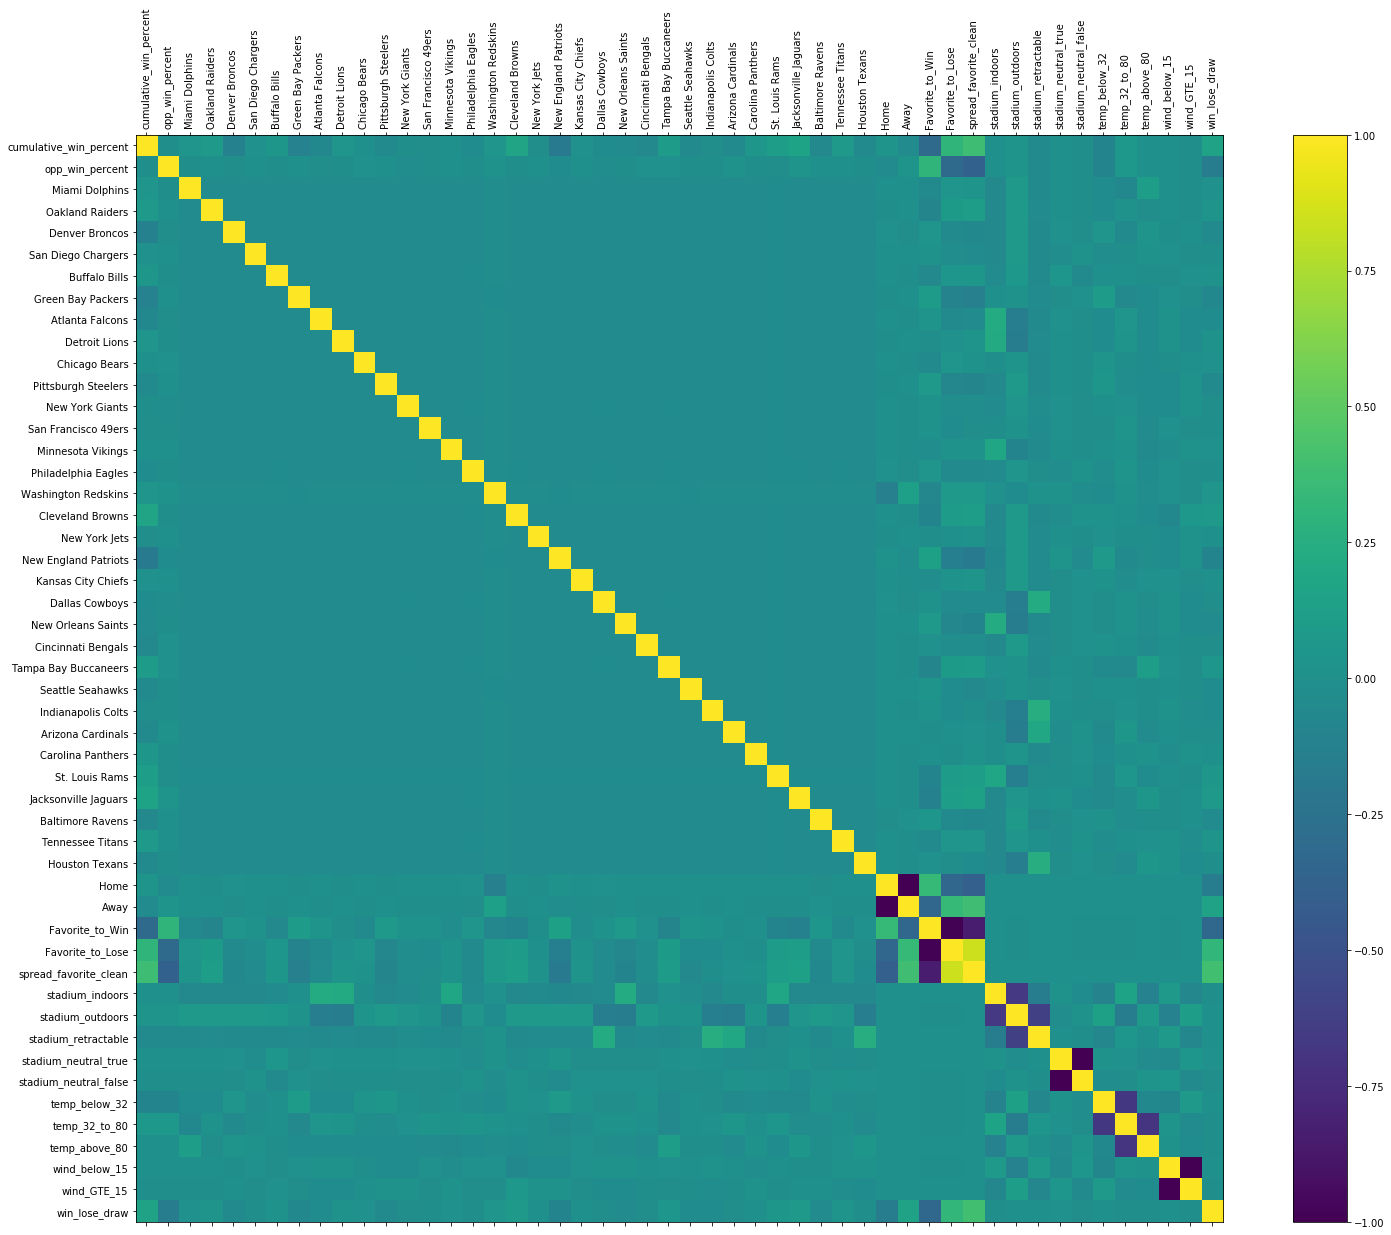

In [10]:
# Create correlation matrix to analyze correlations among pairs of features
names = games_train_filtered.columns[:-1]
correlations = games_train_filtered.corr()
fig = plt.figure(figsize = [25,20])
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(correlations.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(correlations.columns, rotation = 90)
ax.set_yticklabels(correlations.columns)
plt.show()

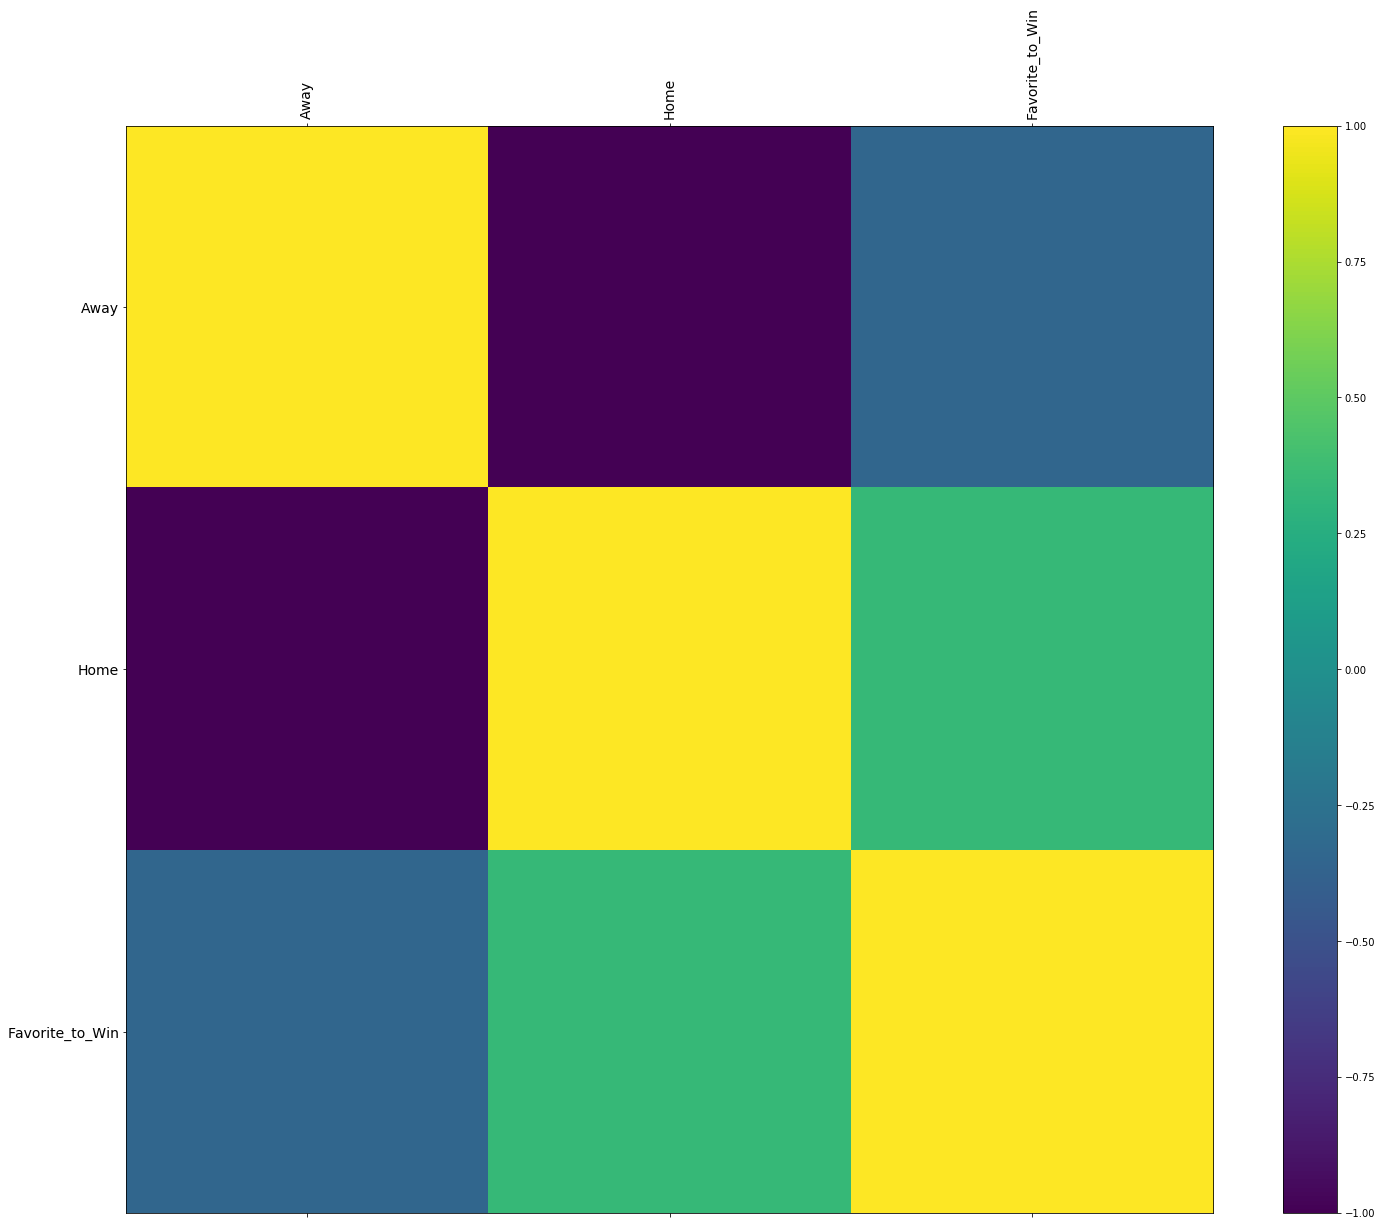

In [11]:
# Zoom in on columns that have more interesting activity from above visaulization
zoom_in_on_columns = ['Away', 'Home', 'Favorite_to_Win']
simpler_correlations = correlations.loc[zoom_in_on_columns, zoom_in_on_columns]

fig = plt.figure(figsize = [25,20])
ax = fig.add_subplot(111)
cax = ax.matshow(simpler_correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(simpler_correlations.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(simpler_correlations.columns, rotation = 90, fontsize = 14)
ax.set_yticklabels(simpler_correlations.columns, fontsize = 14)
plt.show()

## Final Splitting of Data into X and y

### -- Have training and test dataframes
### -- Not yet split into an X or a y
### -- Finish by scaling data

In [12]:
# win_lose_draw is the y column
X_train = games_train_filtered.drop("win_lose_draw", axis=1)
y_train = games_train_filtered["win_lose_draw"].values.reshape(-1, 1)
print(X_train.shape, y_train.shape)

(4140, 49) (4140, 1)


In [13]:
# win_lose_draw is the y column
X_test = games_test_filtered.drop("win_lose_draw", axis=1)
y_test = games_test_filtered["win_lose_draw"].values.reshape(-1, 1)
print(X_test.shape, y_test.shape)

(1004, 49) (1004, 1)


In [14]:
# scale X data
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# 3. Logistic Regression

## -- Typically used for binary dependent variable (0 or 1)

## -- With more than two outcomes, becomes multinomial logistic regression

## -- Our possible outcomes are 0, 1, or 2 (win, lose, or draw)

## -- Code in python works the same

In [15]:
# Create a logistic regression model

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
# Fit the data
classifier.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
# Score the data
logistic_train_score = classifier.score(X_train_scaled, y_train)
logistic_test_score = classifier.score(X_test_scaled, y_test)
print(f'Logistic Regression score on train data is {logistic_train_score}')
print(f'Logistic Regression score on test data is {logistic_test_score}')

Logistic Regression score on train data is 0.6620772946859903
Logistic Regression score on test data is 0.6703187250996016


## Detour - To Use the Vegas Data or Not?

### -- With Vegas data included in features, score is 67%

### -- Problematic to use Vegas data?

### -- What is the score when excluding the Vegas data?

In [18]:
# Re-do training data, this time with no Vegas columns
X_train_no_vegas = X_train.drop(['Favorite_to_Win', 'Favorite_to_Lose', 'spread_favorite_clean'], axis=1)
X_train_no_vegas.shape

(4140, 46)

In [19]:
# Re-do testing data, this time with no Vegas columns
X_test_no_vegas = X_test.drop(['Favorite_to_Win', 'Favorite_to_Lose', 'spread_favorite_clean'], axis=1)
X_test_no_vegas.shape

(1004, 46)

In [20]:
# Scale the data
X_scaler_no_vegas = MinMaxScaler().fit(X_train_no_vegas)
X_train_no_vegas_scaled = X_scaler_no_vegas.transform(X_train_no_vegas)
X_test_no_vegas_scaled = X_scaler_no_vegas.transform(X_test_no_vegas)

In [21]:
# Re-do logistic regression with non-vegas data
classifier_no_vegas = LogisticRegression()
classifier_no_vegas

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
# Fit
classifier_no_vegas.fit(X_train_no_vegas_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
# Score
print(f'Logistic Regression score on train data (no Vegas) is {classifier_no_vegas.score(X_train_no_vegas_scaled, y_train)}')
print(f'Logistic Regression score on test data (no Vegas) is {classifier_no_vegas.score(X_test_no_vegas_scaled, y_test)}')

Logistic Regression score on train data (no Vegas) is 0.628743961352657
Logistic Regression score on test data (no Vegas) is 0.6105577689243028


## Vegas Data or Not?

#### -- With Vegas data, score is 67%

#### -- No Vegas data, score is 61%

#### -- Vegas data probably includes player-specific information that we do not have access to

#### -- Vegas data is available prior to each week's games

## Conclusion:  Use Vegas Data



## Logistic Regression Results

In [24]:
# generate accuracy dataframe
logistic_predictions = classifier.predict(X_test_scaled)
logistic_accuracy = pd.DataFrame({"Prediction": list(logistic_predictions), "Actual": y_test.ravel()}).reset_index(drop=True)
logistic_accuracy['Correct'] = logistic_accuracy.Prediction == logistic_accuracy.Actual
logistic_accuracy.head(15)

,Prediction,Actual,Correct
0,1,0,False
1,0,1,False
2,0,0,True
3,1,1,True
4,0,0,True
5,1,1,True
6,1,0,False
7,0,1,False
8,1,1,True
9,0,0,True


In [25]:
# Create confusion matrix dataframe
logistic_y_actu = pd.Series(y_test.ravel(), name='Actual')
logistic_y_pred = pd.Series(logistic_predictions, name='Predicted')

logistic_df_confusion = pd.crosstab(logistic_y_actu, logistic_y_pred)
logistic_df_confusion.columns = ['Win', 'Lose']
logistic_df_confusion.rename(index={
    logistic_df_confusion.index[0]: 'Win',
    logistic_df_confusion.index[1]: 'Lose',
    logistic_df_confusion.index[2]: 'Draw'
}, inplace=True)
logistic_df_confusion['Draw'] = 0
logistic_df_confusion

,Win,Lose,Draw
Actual,,,
Win,330,170,0
Lose,157,343,0
Draw,2,2,0


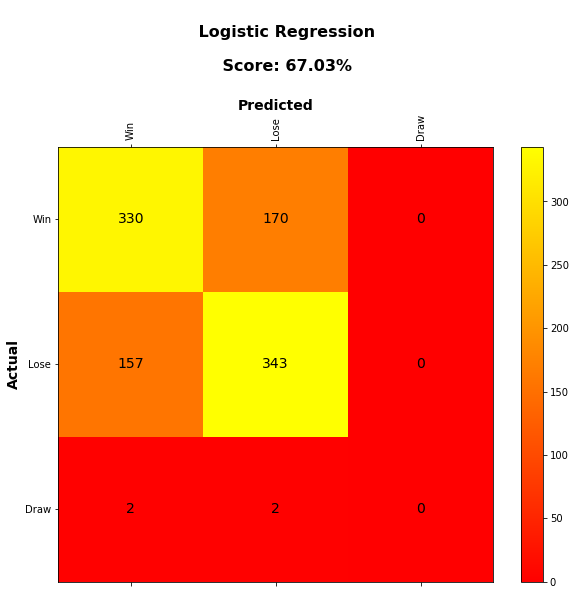

In [26]:
# Function call to generate Logistic Regression confusion visualization
fig = plt.figure(figsize = (10,8))
prep_confusion_visual(logistic_df_confusion, 111, logistic_test_score, 'Logistic Regression')
plt.show()

# 4.  Support Vector Machine (SVM)

## -- Can be used for both regression or classification (usually for classification)

## -- Goal is to find hyperplane that maximizes distance between classes

## -- Typically produces good results with relatively low computing resources

![alt text](Images/svm_image.png "SVM Image")

In [27]:
# Create and train model

from sklearn.svm import SVC

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [28]:
# Score model

svm_train_score = svm_model.score(X_train_scaled, y_train)
svm_test_score = svm_model.score(X_test_scaled, y_test)

print(f'SVM score on train data is {svm_train_score}')
print(f'SVM score on test data is {svm_test_score}')

SVM score on train data is 0.6618357487922706
SVM score on test data is 0.6723107569721115


In [29]:
# Grid search

from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [1, 5, 10],
    'gamma': [0.0001, 0.001, 0.01]
}
grid = GridSearchCV(svm_model, param_grid, verbose = 3)

In [30]:
# Grid fit

grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... C=1, gamma=0.0001, score=0.6642547033285094, total=   0.3s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ...... C=1, gamma=0.0001, score=0.6613488034807832, total=   0.3s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ...... C=1, gamma=0.0001, score=0.6598984771573604, total=   0.3s
[CV] C=1, gamma=0.001 ................................................
[CV] ....... C=1, gamma=0.001, score=0.6642547033285094, total=   0.3s
[CV] C=1, gamma=0.001 ................................................
[CV] ....... C=1, gamma=0.001, score=0.6613488034807832, total=   0.3s
[CV] C=1, gamma=0.001 ................................................
[CV] ....... C=1, gamma=0.001, score=0.6598984771573604, total=   0.3s
[CV] C=1, gamma=0.01 .................................................
[CV] ........ C=1, gamma=0.01, score=0.6642547033285094, total=   0.6s
[CV] C=1, gamma=0.01 .................................................
[CV] ........ C=1, gamma=0.01, score=0.6613488034807832, total=   0.3s
[CV] C=1, gamma=0.01 .................................................
[CV] ........ C=1, gamma=0.01, score=0.6598984771573604, total=   0.3s
[CV] C=5, gamma=0.0001 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   18.1s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 5, 10], 'gamma': [0.0001, 0.001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [31]:
# Grid results

print(grid.best_params_)
print(grid.best_score_)

{'C': 1, 'gamma': 0.0001}
0.6618357487922706


## SVM Results

In [32]:
# accuracy dataframe

svm_predictions = svm_model.predict(X_test_scaled)
svm_accuracy = pd.DataFrame({"Prediction": list(svm_predictions), "Actual": y_test.ravel()}).reset_index(drop=True)
svm_accuracy['Correct'] = svm_accuracy.Prediction == svm_accuracy.Actual
svm_accuracy.head(15)

,Prediction,Actual,Correct
0,1,0,False
1,0,1,False
2,0,0,True
3,1,1,True
4,0,0,True
5,1,1,True
6,1,0,False
7,0,1,False
8,1,1,True
9,0,0,True


In [33]:
# Create confusion matrix dataframe
svm_y_actu = pd.Series(y_test.ravel(), name='Actual')
svm_y_pred = pd.Series(svm_predictions, name='Predicted')

svm_df_confusion = pd.crosstab(svm_y_actu, svm_y_pred)
svm_df_confusion.columns = ['Win', 'Lose']
svm_df_confusion.rename(index={
    svm_df_confusion.index[0]: 'Win',
    svm_df_confusion.index[1]: 'Lose',
    svm_df_confusion.index[2]: 'Draw'
}, inplace=True)
svm_df_confusion['Draw'] = 0
svm_df_confusion

,Win,Lose,Draw
Actual,,,
Win,337,163,0
Lose,162,338,0
Draw,2,2,0


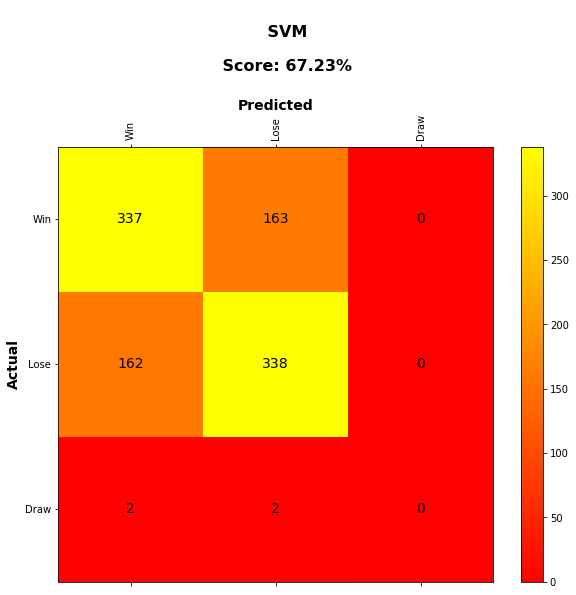

In [34]:
# Function call to generate SVM confusion matrix visualization
fig = plt.figure(figsize = (10,8))
prep_confusion_visual(svm_df_confusion, 111, svm_test_score, 'SVM')
plt.show()

# 5. Deep Learning

## -- Multiple layers of algorithms working to interpret data

## -- Artificial neural networks

## -- Typically works better with large datasets

![alt text](Images/deep_learning_image.png "Deep Learning Image")

In [35]:
# Create and summarize model
# Use 147 nodes in each hidden unit (3x 49 columns of X data)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

deep_model = Sequential()
deep_model.add(Dense(units=147, activation='relu', input_dim=len(X_train.columns)))
deep_model.add(Dense(units=147, activation='relu'))
deep_model.add(Dense(units=3, activation='softmax'))

deep_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

deep_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 147)               7350      
_________________________________________________________________
dense_1 (Dense)              (None, 147)               21756     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 444       
Total params: 29,550
Trainable params: 29,550
Non-trainable params: 0
_________________________________________________________________


In [36]:
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)
# encoded_y_train = label_encoder.transform(y_train)
# encoded_y_test = label_encoder.transform(y_test)

# y_train_categorical = to_categorical(encoded_y_train)
# y_test_categorical = to_categorical(encoded_y_test)

In [37]:
# Fit

deep_model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=2
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
 - 1s - loss: 0.6700 - acc: 0.6500
Epoch 2/60
 - 0s - loss: 0.6438 - acc: 0.6614
Epoch 3/60
 - 0s - loss: 0.6417 - acc: 0.6618
Epoch 4/60
 - 0s - loss: 0.6321 - acc: 0.6671
Epoch 5/60
 - 0s - loss: 0.6281 - acc: 0.6729
Epoch 6/60
 - 0s - loss: 0.6228 - acc: 0.6751
Epoch 7/60
 - 0s - loss: 0.6194 - acc: 0.6792
Epoch 8/60
 - 0s - loss: 0.6105 - acc: 0.6857
Epoch 9/60
 - 0s - loss: 0.6087 - acc: 0.6780
Epoch 10/60
 - 0s - loss: 0.6030 - acc: 0.6877
Epoch 11/60
 - 0s - loss: 0.5966 - acc: 0.6954
Epoch 12/60
 - 0s - loss: 0.5896 - acc: 0.6976
Epoch 13/60
 - 0s - loss: 0.5863 - acc: 0.7014
Epoch 14/60
 - 0s - loss: 0.5784 - acc: 0.7060
Epoch 15/60
 - 0s - loss: 0.5721 - acc: 0.7138
Epoch 16/60
 - 0s - loss: 0.5709 - acc: 0.7056
Epoch 17/60
 - 0s - loss: 0.5663 - acc: 0.7087
Epoch 18/60
 - 0s - loss: 0.5596 - acc: 0.7179
Epoch 19/60
 - 0s - loss: 0.5566 - acc: 0.7138
Epoch 20/60
 - 0s - loss: 0.5492 - acc: 0.7217
Epoch 21/60
 - 0s - l

In [38]:
# Score

deep_model_loss, deep_model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test_categorical, verbose = 2)

print(
    f'''
    Deep Neural Network
    Loss: {deep_model_loss}
    Accuracy: {deep_model_accuracy}
    '''
)

 - 0s - loss: 1.0971 - acc: 0.6275

    Deep Neural Network
    Loss: 1.0970730620076456
    Accuracy: 0.6274900436401367
    


## Deep Learning Results

In [39]:
# Create accuracy dataframe
encoded_prediction = deep_model.predict_classes(X_test_scaled)
deep_predictions = label_encoder.inverse_transform(encoded_prediction)

deep_accuracy = pd.DataFrame({"Prediction": list(deep_predictions), "Actual": y_test.ravel()}).reset_index(drop=True)
deep_accuracy['Correct'] = deep_accuracy.Prediction == deep_accuracy.Actual
deep_accuracy.head(15)

,Prediction,Actual,Correct
0,1,0,False
1,0,1,False
2,0,0,True
3,1,1,True
4,0,0,True
5,1,1,True
6,1,0,False
7,1,1,True
8,1,1,True
9,0,0,True


In [42]:
deep_y_actu = pd.Series(y_test.ravel(), name='Actual')
deep_y_pred = pd.Series(deep_predictions, name='Predicted')
deep_df_confusion = pd.crosstab(deep_y_actu, deep_y_pred)

deep_df_confusion.columns = ['Win', 'Lose']

deep_df_confusion.rename(index={
    deep_df_confusion.index[0]: 'Win',
    deep_df_confusion.index[1]: 'Lose',
    deep_df_confusion.index[2]: 'Draw'
}, inplace=True)

deep_df_confusion['Draw'] = 0

deep_df_confusion

,Win,Lose,Draw
Actual,,,
Win,294,206,0
Lose,164,336,0
Draw,1,3,0


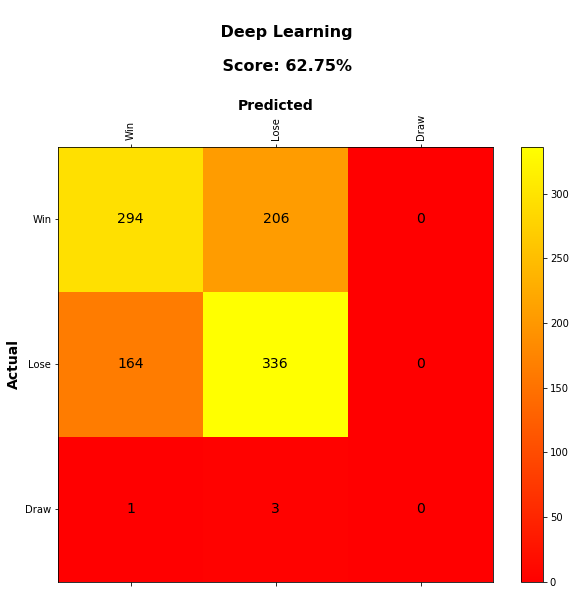

In [43]:
fig = plt.figure(figsize = (10,8))
prep_confusion_visual(deep_df_confusion, 111, deep_model_accuracy, 'Deep Learning')
plt.show()

# 6. Conclusion

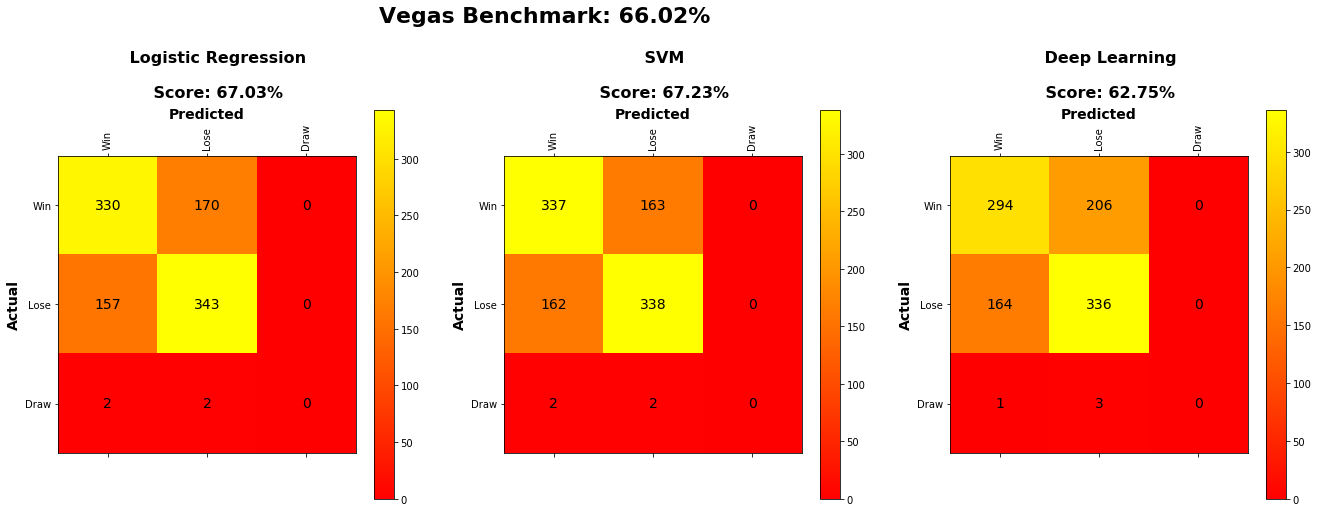

In [44]:
fig = plt.figure(figsize = (18,8))
prep_confusion_visual(logistic_df_confusion, 131, logistic_test_score, 'Logistic Regression')
prep_confusion_visual(svm_df_confusion, 132, svm_test_score, 'SVM')
prep_confusion_visual(deep_df_confusion, 133, deep_model_accuracy, 'Deep Learning')
plt.subplots_adjust(right=1.1, top=0.8)
plt.suptitle('Vegas Benchmark: 66.02%', fontweight = 'bold', fontsize = 22)
plt.show()

# Questions